# Upload to cloud
(tutorial:upload_to_cloud)=

A key feature of OME-Zarr is that data can be stored on cloud object storage, such as AWS S3, Google Cloud Storage, or Azure Blob Storage.
However, institutions can set up their own S3-compatible infrastructures so to not rely on commercial providers.
In this tutorial, we will use the S3 playground provided by the [minio project](https://www.min.io).

Link: [https://play.min.io/](https://play.min.io:9443).

Credentials for this playground are public:
- Access Key (aka user name): `Q3AM3UQ867SPQQA43P2F`
- Secret Key (aka password): `zuf+tfteSlswRu7BJ86wekitnifILbZam1KYY3TG`

## *Optional*: Important concepts about S3

**Buckets**: S3 spaces are typically organized in *buckets*.

- A bucket is a top-level container for objects (files).
- Bucket names must be globally unique across all S3 users.
- Bucket names must follow specific naming conventions (e.g., no uppercase letters, no underscores, etc.).
- Buckets can be created, listed, and deleted using S3-compatible tools or libraries

**Flattened namespace**: Unlike traditional file systems, S3 uses a flat directory structure.
This means that there are no actual folders or directories; instead, the concept of folders is simulated using object key prefixes.
For example, an object with the key `folder1/folder2/file.txt` is stored in a bucket, but there are no actual `folder1` or `folder2` directories.

**Access Control**: S3 provides fine-grained access control mechanisms to manage permissions for buckets and objects.
Generally, data on S3 can be accessed using an `Access Key` and a `Secret Key`.
Depending on the host institution, the `endpoint` URL can be specified to point to a S3-compatible service that is not part of [AWS](https://aws.amazon.com/de/).


In [1]:
from minio import Minio
import os
import tqdm


## Creating a bucket

Let's connect to the minio playground, create a bucket and upload some sample data

In [2]:
access_key = 'Q3AM3UQ867SPQQA43P2F'
secret_key = 'zuf+tfteSlswRu7BJ86wekitnifILbZam1KYY3TG'
endpoint = 'play.min.io'

In [3]:
client = Minio(endpoint=endpoint, access_key=access_key, secret_key=secret_key, secure=True)

We can see that people have already created some buckets in this playground:

In [ ]:
# List buckets
buckets = client.list_buckets()
buckets

In [5]:
# create a new bucket. Spoiler "test-bucket" already exists.
bucket_name = '32098230xm8302ysd'
if not client.bucket_exists(bucket_name):
    client.make_bucket(bucket_name)

Alternatively, you can log in to the web interface at [https://play.min.io/](https://play.min.io/) using the provided credentials and create a new bucket there:

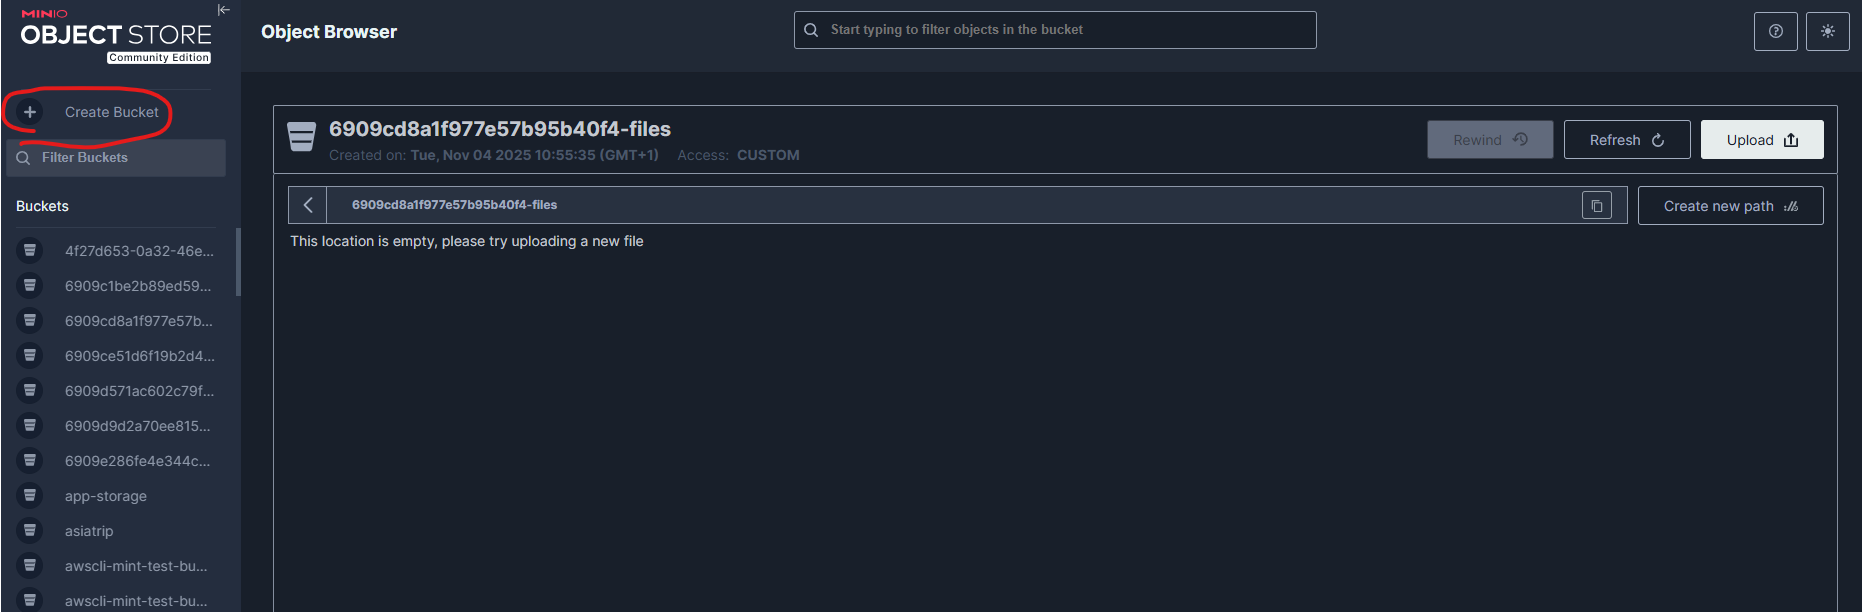

Once your bucket has been created, create a small test file to upload:

In [6]:
test_file_path = "testfile.txt"
with open(test_file_path, "w") as f:
    f.write("This is a test file for MinIO upload.\n")

#### Exercise

Use the `fput_object` method of the `client` object to upload the `test.txt` file to your bucket.

In [ ]:
client.fput_object?

#### Exercise

Use the `fget_object` method of the `client` object to download the `test.txt` file from your bucket and print its contents.

In [ ]:
client.fget_object?

## Upload image data

Now let's upload our ome-zarr from the [previous notebook](#tutorial:save_ome_zarr) to an S3 bucket.
The Minio playground does not allow for very large uploads, so we need to upload elsewhere.
We can still use the minio client for this, though!

In [11]:
endpoint = 's3.zih.tu-dresden.de'
access_key = 'WFCEK72DCU6I0W7XFKRF'
secret_key = '4wf8MNj7PEc8vDingDEcDPYh3hfX9NLA34QZJHtP'

client = Minio(endpoint=endpoint, access_key=access_key, secret_key=secret_key, secure=True)

bucket_name = '2309xx23ds'
if not client.bucket_exists(bucket_name):
    client.make_bucket(bucket_name)

In [12]:
ome_zarr_path = 'cells3d.ome.zarr'

file_count = sum(len(files) for _, _, files in os.walk(ome_zarr_path))  # get total file count
with tqdm.tqdm(total=file_count) as pbar:  # Do tqdm this way
    for root, subdirs, files in os.walk(ome_zarr_path):
        for file in files:
            path = os.path.join(root, file)
            s3_object_name = path.replace("\\", "/")  # For Unix compatibility
            client.fput_object(bucket_name, s3_object_name, path)
            pbar.update(1)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [01:36<00:00,  2.00s/it]


## Minio client from CLI

Obviously, that's fairly slow. You can improve the upload performance a fair bit my using the [minio client](https://github.com/minio/mc) (mc) from the command line. Instructions can be found here:

- [macOS](https://github.com/minio/mc?tab=readme-ov-file#macos)
- [Windows](https://github.com/minio/mc?tab=readme-ov-file#microsoft-windows)

```{note}
Minio client requires admin privileges for usage.
```

As a first step, configure the minio client with the credentials to a working s3 storage:

```bash
mc alias set halfway_i2k https://s3.zih.tu-dresden.de WFCEK72DCU6I0W7XFKRF 4wf8MNj7PEc8vDingDEcDPYh3hfX9NLA34QZJHtP --insecure --api S3v4
mc alias ls halfway_i2k
```

Verify that the configuration worked. You should see something like this in the output:

```bash
halfway_i2k
  URL       : https://s3.zih.tu-dresden.de
  AccessKey : WFCEK72DCU6I0W7XFKRF
  SecretKey : 4wf8MNj7PEc8vDingDEcDPYh3hfX9NLA34QZJHtP
  API       : S3v4
  Path      : auto
  Src       : C:\Users\johan\mc\config.json
```

Then navigate to the folder with the ome-zarr image you'd want to upload and run the following command:

```bash
mc mirror --overwrite .\cells3d.ome.zarr\ halfway_i2k/<your-bucket-name>/
```

Next, let's interact with the S3 data from different viewers.
On to the next notebook!